In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

import time

seed=47

In [2]:
## client data
client_test = pd.read_csv("/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/test/client_test.csv")
client_train = pd.read_csv("/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/train/client_train.csv")
## invoice data
invoice_train = pd.read_csv("/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/train/invoice_train.csv")
invoice_test = pd.read_csv("/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/test/invoice_test.csv")
## sample submission

/tmp/ipykernel_28/2858719808.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv("/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/train/invoice_train.csv")


In [3]:
sample_submission = pd.read_csv("/kaggle/input/fraud-detection-in-electricity-and-gas-consumption/Sample_Submission.csv")

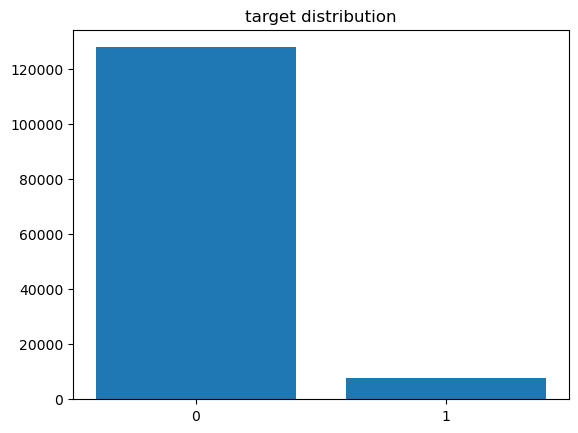

In [4]:
ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()

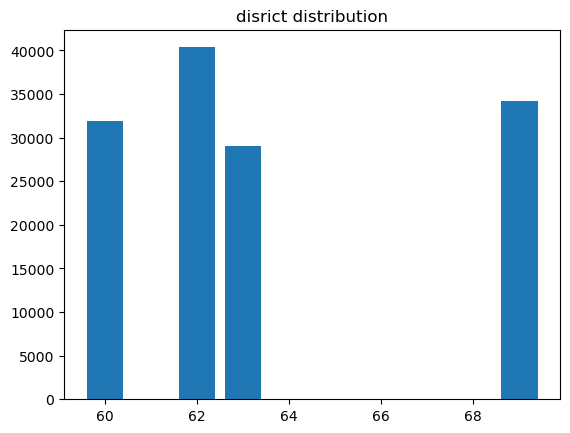

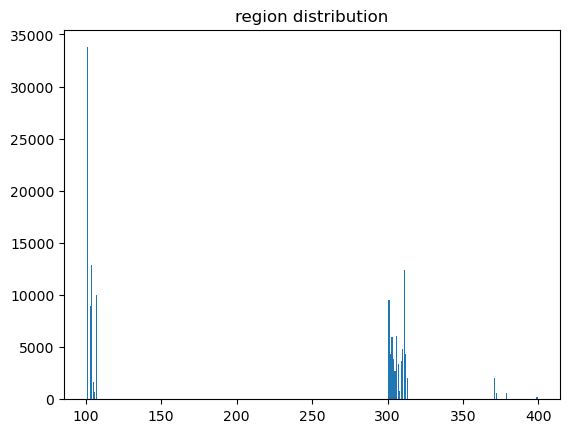

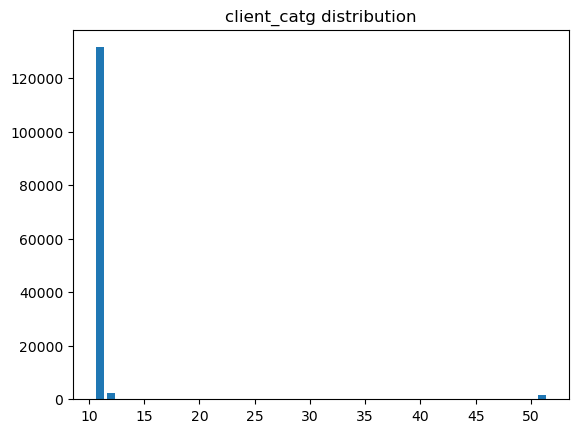

In [5]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

In [6]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [7]:


def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'],infer_datetime_format=True)
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'],infer_datetime_format=True, dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

In [8]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [9]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [10]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

In [11]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)


print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))



def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

Initial number of columns:  29
Number of columns now:  111


In [12]:
train_df = drop(train_df2)
test_df = drop(test_df2)
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

In [13]:

from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb

category_cols = ['disrict', 'client_catg', 'region']

def objective(trial:Trial):
    
    gc.collect()
    models=[]
    validScore=0
   
    model,log = fitLGBM(trial,X,y)
    
    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)
    
    return validScore

In [14]:
def fitLGBM(trial,X, y):
    
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':seed
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = LGBMClassifier(**params)
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        res.append(roc_auc_score(y_valid, preds[:,1]))
    
    err = np.mean(res)
    
    return model, err

In [15]:
model = LGBMClassifier(random_state=seed, n_estimators=830,num_leaves=454, max_depth=61,
                       learning_rate=0.006910869038433314, min_split_gain=0.00667926424629105, 
                       feature_fraction=0.3764303138879782, bagging_freq=8)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 verbose=False, early_stopping_rounds=100)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs

In [16]:
probs = calc(X, y, model, stkfold)

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' 

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' 

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' 

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' 

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


ROC AUC: 0.884911


In [17]:
submission = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })
submission.to_csv('submission.csv', index=False)